In [50]:
import os, re 
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline

In [81]:
def get_results_dir(model_name, dataset_name, model_type, fault_type):
    d = {
        'vgg16': {
            'cifar10': {
                'full': {
                   
                    'faults_layer': './logs/vgg16/cifar10/int8/faults_layer',
                    'faults_layer_masking': './logs/vgg16/cifar10/int8/faults_layer_masking',
                    'faults_layer_p': './logs/vgg16/cifar10/int8/faults_layer_p',
                },
               
            }
        }
        
    }
    return d.get(model_name).get(dataset_name).get(model_type).get(fault_type)

def get_fault_free_accuracy(model_name, dataset_name, model_type):
    d = {'vgg16': {
        'cifar10': {
            'full': 0.9375, 
          }},
        }
        
    return d[model_name][dataset_name][model_type]

model_name = 'vgg16'
dataset_name = 'cifar10'

model_types = ['full']
fault_types = ['faults_layer_p']
# fault_types = ['faults_layer', 'faults_layer_masking']


In [83]:
def parse_log(log_path):
    # trial: 9, bit_position: 0, n_faults: 1, total_params: 1728, 
    # flipped_bits: 1 (1.808449e-05), changed_params: 1 (5.787037e-04), test_time: 2, test_accuracy: 0.938800
    result = {}
    with open(log_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if line:
                flipped_bits, changed_params, test_accuracy = 0, 0, None 
                items = line.split(',')
                for item in items:
                    if 'total_params' in item:
                        total_params = int(item.split()[1])
                    if 'changed_params' in item:
                        changed_params = int(item.split()[1])
                    if 'test_accuracy' in item:
                        test_accuracy = float(item.split()[1])
                    if 'trial' in item:
                        trial = int(item.split()[1])
                if test_accuracy:
                    result[trial] = [total_params, changed_params, test_accuracy]
    result = np.asarray([result[trial_id] for trial_id in sorted(result.keys())])
    return result 

def load_results(model_type, fault_type):
    results = {}
    results_dir = get_results_dir(model_name, dataset_name, model_type, fault_type)
    if not results_dir:
        return None 
    
    # ./cifar/l1-norm-pruning/logs/vgg16/cifar10/faults_layer/param-0/bit-0/nbits-1
    param_id_folders = os.listdir(results_dir)
    for param_id_folder in param_id_folders:
        param_id = int(param_id_folder.split('-')[-1])
        param_id_path = os.path.join(results_dir, param_id_folder)
        if param_id not in results:
            results[param_id] = {} 
        # get the bit folder 
        for bit_position_folder in os.listdir(param_id_path):
            bit_position = int(bit_position_folder.split('-')[-1])
            bit_position_path = os.path.join(param_id_path, bit_position_folder)
            if bit_position not in results[param_id]:
                results[param_id][bit_position] = {} 
            # get number of bits folder
            for nbits_folder in os.listdir(bit_position_path):
                nbits = float(nbits_folder[2:])
                log_path = os.path.join(bit_position_path, nbits_folder, 'logs.txt')
                if os.path.isfile(log_path):
                    results[param_id][bit_position][nbits] = parse_log(log_path)
    return results 
        
data = {} # model_type -> fault_type -> param_id -> bit_position -> n_bits 
for model_type in model_types:
    data[model_type] = {} 
    for fault_type in fault_types:
        results = load_results(model_type, fault_type)
        if results:
            data[model_type][fault_type] = results 

param_id = 0 
print(data[model_type][fault_type][param_id][0][0.1].shape)


(5, 3)


prec1: 0.9375
[11, 6, 5, -3, -15, 3, -12, -27, 0, 15, 10, 5, 6, -6, 6, -4, -18, 4, 13, 9, 5, 4, -6, 4, -9, -21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


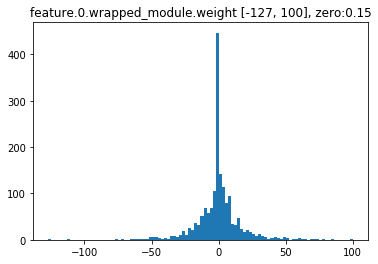

[9, -11, -4, -2, -23, -7, 6, -13, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -9, -4, 0, -3, 1, 3, 2, 5, 2, -5, -5, 0, -7, -5, 6, -2, -4, 5, -8, 1, 3, -7, 0, 0, -5, -4, -9, -23, -7, -2, -14]


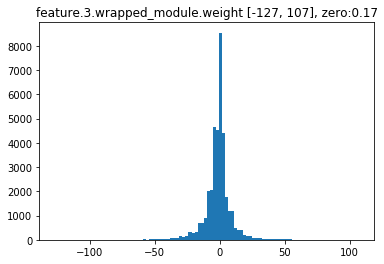

[-5, 8, -6, 14, 7, 8, 30, 15, -5, 17, -5, -18, 27, 5, -1, 32, 6, -5, -8, -31, -13, -27, -46, -10, 6, -16, -13, 18, 17, 4, 19, 7, -2, 10, 8, -4, -12, -24, -10, 4, -18, -11, 6, 13, 7, -18, -1, 4, 1, -6]


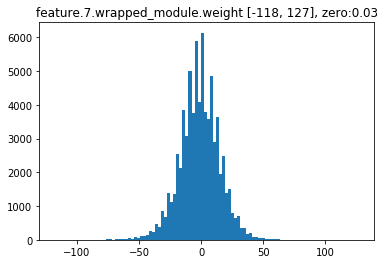

[-22, -27, -22, 14, -8, 7, 8, 1, 15, 2, -19, 4, 12, 9, 18, 36, 39, 26, -17, -18, -11, -1, 8, -26, 11, 9, -24, -10, -9, -17, 28, 19, 7, 12, 23, 7, -42, -48, -38, 7, 1, -9, 10, 15, 23, 31, 16, -6, -6, -19]


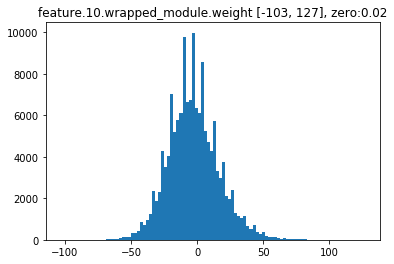

[-1, -8, -5, 1, -3, -3, -4, -5, -7, -19, -18, -7, -10, -9, -10, 0, 0, 0, -8, -11, -7, -4, -6, 0, -9, -8, -4, 28, 3, 0, 7, -13, -14, 2, -9, -6, -13, -7, -10, -4, -10, 2, 3, -6, 2, -4, -1, 12, 5, -8]


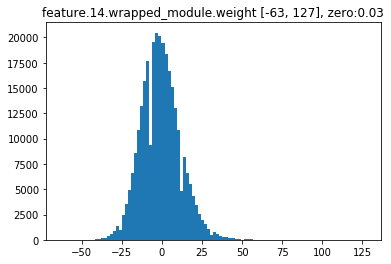

[5, 7, -5, 5, -6, -21, -14, -20, -32, -3, -11, -17, -19, -18, 1, 36, 25, 23, 1, 12, 12, -2, 6, 16, 12, -12, -1, -16, -27, -17, -21, -13, -14, -22, 5, 10, 9, -2, -19, 17, 13, -15, 33, 6, -2, -27, -27, -13, -12, 9]


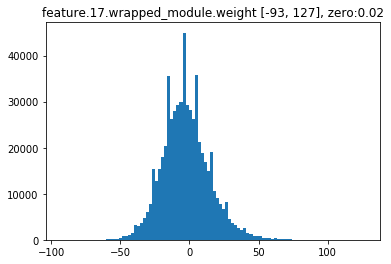

[3, 13, 10, -7, 3, 10, -3, -9, -7, 7, -7, 4, 13, 13, 13, 0, -2, 11, -6, -13, -14, -7, -14, -13, -4, -7, 0, 4, 7, 23, 12, 32, 21, 1, 9, -22, 1, -9, -1, -14, -21, -1, -8, -16, -12, -7, -26, 2, -23, -9]


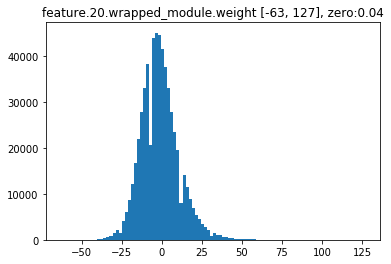

[-8, -3, -11, -9, 0, -17, 7, 0, -1, 18, 14, -8, -5, -1, -8, 2, 1, 12, -10, 3, -10, -13, -6, -19, -7, -16, -29, 4, 3, 2, 4, 18, 14, 6, 29, 7, -7, -7, 1, 0, -5, -9, 0, 11, 10, -6, -10, -4, -6, -15]


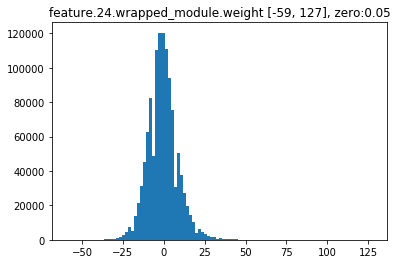

[13, 5, 4, -1, -7, 3, -11, -4, -4, -7, -4, -3, -11, -13, -3, 8, 13, 8, 7, -9, -7, -3, -9, -5, -2, -12, -9, 1, 3, 2, -1, -4, -1, 4, 4, 8, -2, -4, 1, 8, 9, 3, 1, -1, 3, -5, 26, -3, 18, 24]


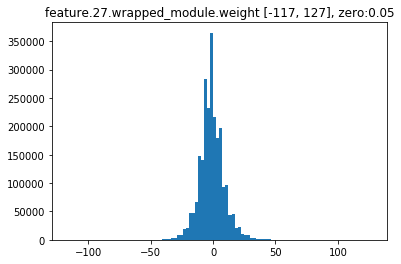

[-4, -3, 2, 2, -7, 3, 14, 3, 2, 7, 3, 1, 6, -1, -6, -8, 3, 3, 7, -4, -3, -2, -3, 0, 7, 2, 0, -3, 15, 10, 6, 12, -19, -14, 25, 11, -7, -8, -12, -2, -3, -2, 11, -23, 1, 3, 3, -8, -1, -4]


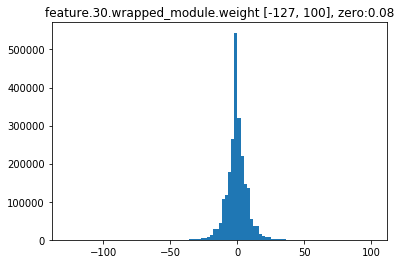

[2, -14, 11, 14, -19, 8, -6, 7, -7, 3, -3, -3, 4, 2, 1, -4, 3, -3, 12, 13, -13, -31, 12, -5, 3, -24, -3, -1, -8, 1, 4, -8, 8, -3, -1, 0, -17, -2, 10, -10, 9, 5, 4, -20, 3, 10, -2, -1, -24, 20]


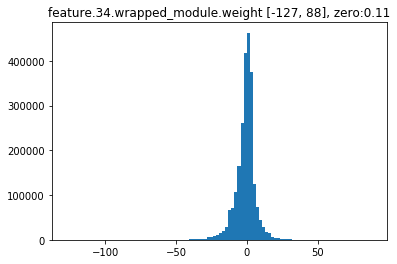

[1, -5, -6, 6, -26, 32, 5, -14, 5, 0, -27, 11, -1, 20, 8, -14, 7, -2, -2, 1, 1, 4, -11, 7, -2, -11, 6, -4, -5, -12, -3, -5, 14, -1, -22, 15, -2, -7, 0, -8, 19, -2, -4, 6, -1, -2, -6, -1, -4, 4]


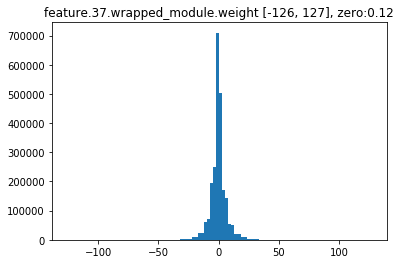

[2, 6, -3, 0, 3, -2, -2, -2, 0, 0, -1, -1, 0, 0, 3, 0, 0, 2, -4, -3, 0, -5, -4, 6, -1, -1, 4, -2, -1, 3, -3, -3, 2, 0, -2, -1, 2, 5, 0, 1, 4, -1, -1, -1, 0, 0, 0, 0, -1, -1]


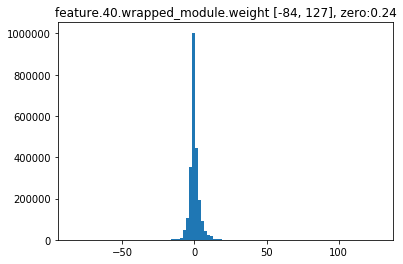

[5, 1, 1, 3, 3, 0, 3, 15, -1, 5, -4, -1, -3, 0, 2, 1, 4, -1, 2, 0, 7, -3, 0, -5, 2, 9, 4, -1, 1, 4, 0, 3, 0, -4, 2, 1, 2, -1, -8, -10, -4, 1, 2, 5, 2, 1, 4, 1, 2, -2]


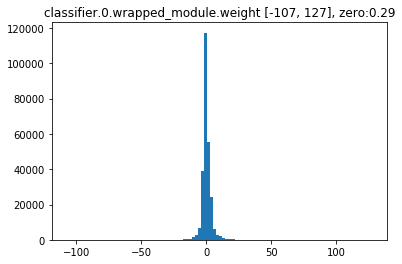

[-31, 5, 13, -52, -18, -5, 22, -51, -4, 9, -26, -25, 0, -71, -1, -6, -30, 21, -8, 25, 37, -86, -33, -14, 3, 40, 13, 20, -28, -2, 53, -18, 17, -28, -48, -8, 14, -2, -5, 17, 18, 25, -2, 14, 8, -21, -1, -54, 14, -37]


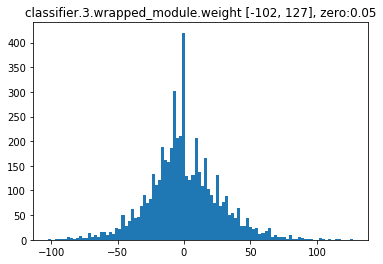

In [84]:
import torch 

model_path = './logs/'+ model_name +'/' + dataset_name +'/int8/quantized.pth.tar'
checkpoint = torch.load(model_path)
prec1 = checkpoint['prec1']
print('prec1:', prec1)
state_dict = checkpoint['state_dict']
param_id_to_name = {}
param_id_to_shape = {} 
param_id = 0 
weights_id = []

for key in state_dict:
    tensor = state_dict[key]
    if len(tensor.size()) >= 2:
        weights_id.append(param_id)
        param_id_to_shape[param_id] = tuple(tensor.size())
        
    if 'weight' in key or 'bias' in key:
        param_id_to_name[param_id] = key
        param_id += 1
    if len(tensor.size()) < 2:
        continue
    minv, maxv = tensor.min().item(), tensor.max().item() 
    tensor = tensor.cpu().numpy().ravel()
    print([int(x) for x in tensor[:50]])
    plt.hist(tensor, bins=100)
#     plt.plot(tensor.cpu().numpy().ravel())
    zeros = sum([x==0 for x in tensor])
    plt.title(key+' [%d, %d], zero:%.2f' %(minv, maxv, zeros/len(tensor)))
    plt.show()

In [85]:
print(len(param_id_to_name), param_id_to_name)

45 {0: 'feature.0.wrapped_module.weight', 1: 'feature.1.weight', 2: 'feature.1.bias', 3: 'feature.3.wrapped_module.weight', 4: 'feature.4.weight', 5: 'feature.4.bias', 6: 'feature.7.wrapped_module.weight', 7: 'feature.8.weight', 8: 'feature.8.bias', 9: 'feature.10.wrapped_module.weight', 10: 'feature.11.weight', 11: 'feature.11.bias', 12: 'feature.14.wrapped_module.weight', 13: 'feature.15.weight', 14: 'feature.15.bias', 15: 'feature.17.wrapped_module.weight', 16: 'feature.18.weight', 17: 'feature.18.bias', 18: 'feature.20.wrapped_module.weight', 19: 'feature.21.weight', 20: 'feature.21.bias', 21: 'feature.24.wrapped_module.weight', 22: 'feature.25.weight', 23: 'feature.25.bias', 24: 'feature.27.wrapped_module.weight', 25: 'feature.28.weight', 26: 'feature.28.bias', 27: 'feature.30.wrapped_module.weight', 28: 'feature.31.weight', 29: 'feature.31.bias', 30: 'feature.34.wrapped_module.weight', 31: 'feature.35.weight', 32: 'feature.35.bias', 33: 'feature.37.wrapped_module.weight', 34: 'fe

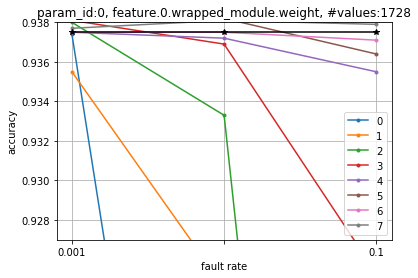

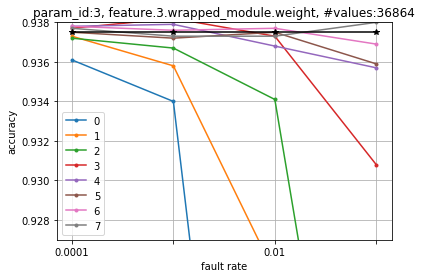

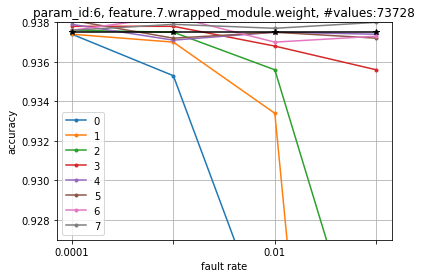

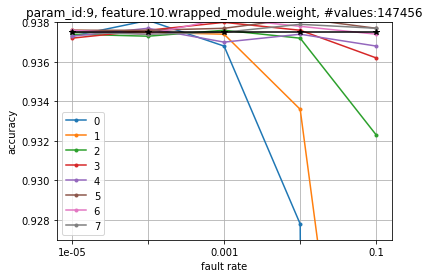

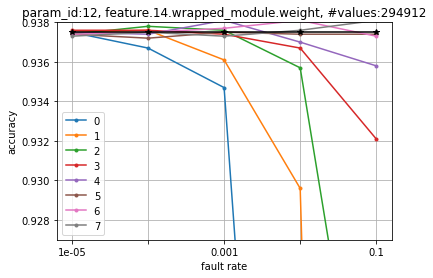

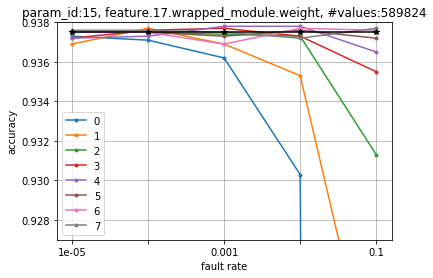

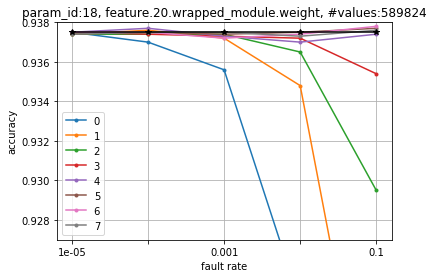

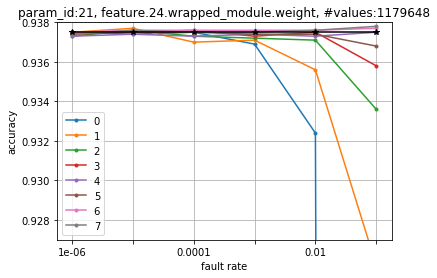

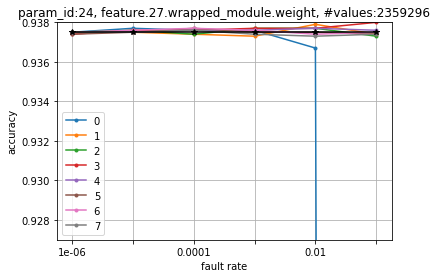

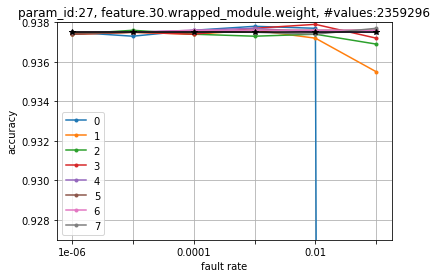

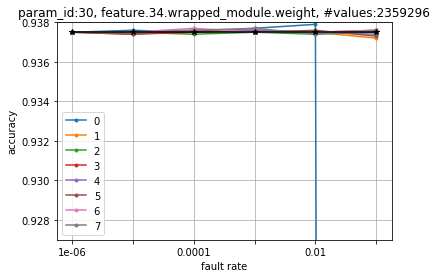

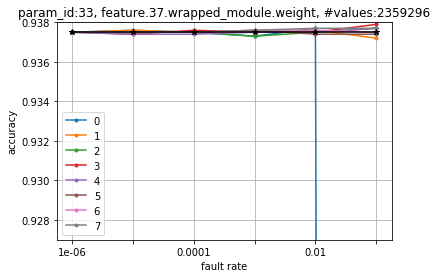

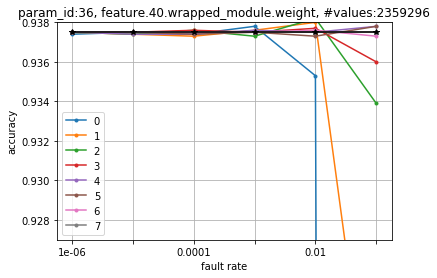

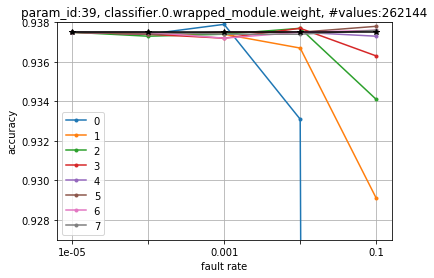

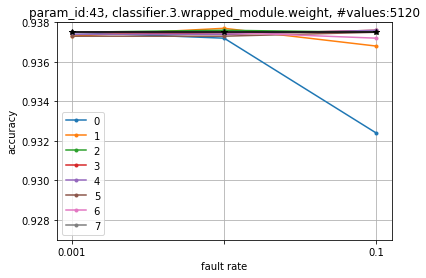

In [86]:
# compare same param_id, same bit_position, x: n_bits, y: accuracy 
for model_type in model_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
    for fault_type in fault_types:
        if 'masking' in fault_type:
            continue 
        for param_id in sorted(data[model_type][fault_type].keys()):
            bit_positions = sorted(data[model_type][fault_type][param_id].keys())[:10]
            
            for bit_position in bit_positions:
                res = data[model_type][fault_type][param_id][bit_position]
                fault_rates = sorted(res.keys())
               
                num_values = res[fault_rates[0]][0, 0]
                accuracies = [np.min(res[fault_rate], axis=0)[2] for fault_rate in fault_rates]
                x = np.log10(fault_rates)
                plt.plot(x, accuracies, label=str(bit_position), marker='.')
            plt.legend()    
#             plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
            plt.grid()
            plt.ylabel('accuracy')
            plt.xlabel('fault rate')
            plt.title('param_id:%d, %s, #values:%d' 
                      %(param_id, param_id_to_name[param_id], res[fault_rates[0]][0, 0]))
            plt.xticks(x, [s if not i%2 else '' for i, s in enumerate(map(str, fault_rates))])
            plt.plot(x, [fault_free_accuracy]*len(x), marker='*', color='k')
            plt.ylim(0.927, 0.938)
            plt.show()
                
                

In [56]:
# # compare same param_id, same n_bits, x: bit_position, y: accuracy 
# for model_type in model_types:
#     fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
#     for fault_type in fault_types:
#         for param_id in sorted(data[model_type][fault_type].keys()):
#             bit_positions = sorted(data[model_type][fault_type][param_id].keys())[:12]
#             n_bits_list = sorted(data[model_type][fault_type][param_id][0].keys())
            
#             for n_bits in n_bits_list:   
#                 res = data[model_type][fault_type][param_id]
#                 num_values = res[bit_positions[0]][n_bits][0, 0]
#                 # x: bit_positions
#                 x, accuracies = [], [] 
#                 for bp in bit_positions:
#                     if bp in res:
#                         accuracies.append(np.min(res[bp][n_bits], axis=0)[2])
#                         x.append(bp)
#                 plt.plot(x, accuracies, marker='.', 
#                          label=str((n_bits, round(n_bits*1.0/num_values, 6))))
                
#             plt.legend()    
# #             plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
#             plt.grid()
#             plt.ylabel('accuracy')
#             plt.xlabel('bit position')
#             plt.title('param_id:%d, %s, #values:%d' %(param_id, param_id_to_name[param_id], res[0][1][0, 0])) # 0: bit position; 1: n_bits 
#             plt.xticks(range(len(bit_positions)), map(str, [x if x%2 else '' for x in bit_positions ]))
#             plt.plot(fault_free_accuracy, marker='*', color='r')
#             plt.show()
                

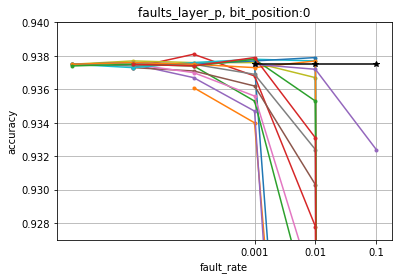

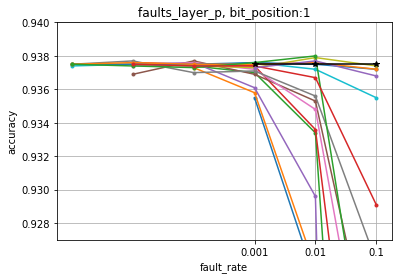

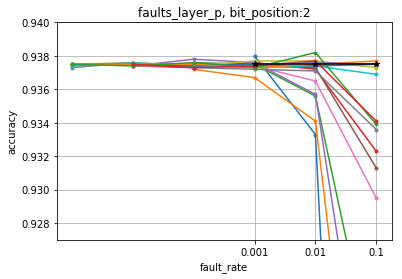

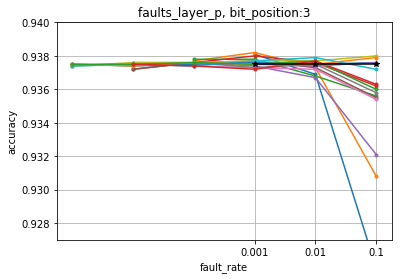

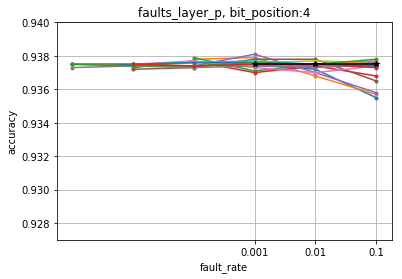

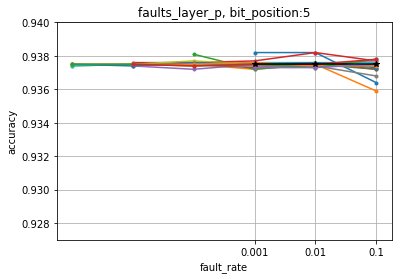

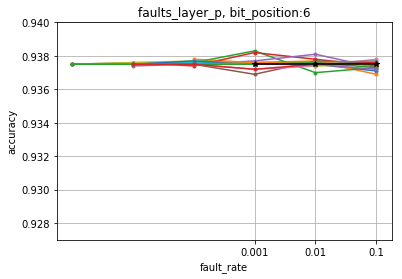

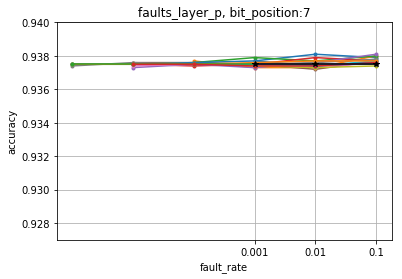

In [88]:
# x: fault_rate, y:accuracy; lengends: param_id 

for model_type in model_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
    for fault_type in fault_types:
        
        for bit_position in range(0, 8):
            
            for param_id in sorted(data[model_type][fault_type].keys()):
                if param_id not in weights_id:
                    continue 
                if bit_position not in data[model_type][fault_type][param_id]:
                    break 
                res = data[model_type][fault_type][param_id][bit_position]
                fault_rates = sorted(res.keys())
                num_values = res[fault_rates[0]][0, 0]
                x = np.log10(fault_rates)

                accuracies = [np.min(res[n_bits], axis=0)[2] for n_bits in fault_rates]
                plt.plot(x, accuracies, 
                         label='%d:%s' %(param_id, param_id_to_shape[param_id]), marker='.')
                
                if param_id in [43]: #[12, 27, 43]:
                    plt.ylim(0.927, 0.94)
#                     plt.legend()    
        #             plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
                    plt.grid()
                    plt.ylabel('accuracy')
                    plt.xlabel('fault_rate')
                    plt.title('%s, bit_position:%d' %(fault_type, bit_position))
                    plt.xticks(x, [s for i, s in enumerate(map(str, fault_rates))])
                    plt.plot(x, [fault_free_accuracy]*len(x), marker='*', color='k')
                    plt.show()


[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 43]
[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 43]
[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 43]
[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 43]


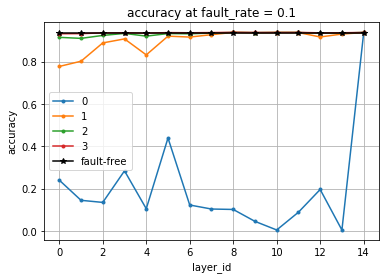

In [80]:

# group using the value at 0.01 
# x: fault_rate, y:accuracy; lengends: param_id 
def param_id_to_layer_id(param_id):
    return int(param_id/3)

for model_type in model_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
    for fault_type in fault_types:
        
        for bit_position in range(0, 4):
            
#             accuracy_list = [] 
            anchors = [] # accuracy at fault_rate = 0.01
            param_ids = []
            anchor_fault_rate = 0.1
            
            for param_id in sorted(data[model_type][fault_type].keys()):
                if param_id not in weights_id:
                    continue 
                if bit_position not in data[model_type][fault_type][param_id]:
                    break 
                
                res = data[model_type][fault_type][param_id][bit_position]
                fault_rates = sorted(res.keys())
#                 num_values = res[fault_rates[0]][0, 0]
#                 x = np.log10(fault_rates)

#                 accuracies = [(fault_rate, np.min(res[fault_rate], axis=0)[2]) for fault_rate in fault_rates]
#                 accuracy_list.append(accuracies)
                if anchor_fault_rate in res:
                    anchors.append(np.median(res[anchor_fault_rate], axis=0)[2])
                    param_ids.append(param_id)
            
#             # group using anchors
#             tmp = sorted(zip(anchors, param_ids, accuracy_list), key=lambda x:x[0])
#             sorted_anchors, sorted_param_ids, sorted_accuracy_list = zip(*tmp)
            
            print(param_ids)
            x = [param_id_to_layer_id(x) for x in param_ids]
            plt.plot(x, anchors, label=str(bit_position), marker='.')
        plt.plot(x, [fault_free_accuracy]*len(x), marker='*', color='k', label='fault-free')
        plt.legend()
        plt.grid()
#         plt.ylim(0.8, 0.95)
        plt.xlabel('layer_id')
        plt.ylabel('accuracy')
        plt.title('accuracy at fault_rate = %s' %(anchor_fault_rate))
            

In [42]:
import pickle 
def load_pickle(load_path, load_name=None, verbose=False):
    if load_name:
        filepath =  os.path.join(load_path, load_name)
    else:
        filepath = load_path 
    if verbose:
        print('Load pickle file:', filepath)
    return pickle.load( open(filepath, "rb" ))

def parse_stats(stats):
    # input format:
    # stats = {param_name: {value: [(flipped bit position, bit value after flip, value after flip)]}}
    # output format: 
    # param_name: #values changed,  #0 -> 1 bit flips, # 1-> 0 bit flips 
    param_stats = {'changed_params':0, 
                               'flip_to_one': np.zeros(8), 
                               'flip_to_zero': np.zeros(8),
                              'value_before_flip': [],
                              'value_after_flip':[], 
                              'flipped_positions': []}
            
    for value_id, flip_list in stats.items():
        param_stats['changed_params'] += 1
        param_stats['value_before_flip'].append(flip_list[0][0])
        param_stats['value_after_flip'].append(flip_list[-1][-1])
        param_stats['flipped_positions'].append([x[1] for x in flip_list])

        for _, flip_pos, flip_bit, flip_value in flip_list:
            if flip_bit:
                param_stats['flip_to_one'][flip_pos] += 1
            else:
                param_stats['flip_to_zero'][flip_pos] += 1
    return param_stats 

def trial_id_to_stats_files(trial_id):
    return str(trial_id)+'.pkl' 

def load_and_average_stats(results_dir, trial_ids):
    stat_dir = os.path.join(results_dir, 'stats')
    stats_files = map(trial_id_to_stats_files, trial_ids)
    avg_param_stats = None 
    for f in stats_files:
        # each trial is saved as a pickle 
        stats = load_pickle(stat_dir, f, verbose=False)
#         print(stats)
         
        param_stats = parse_stats(stats)
        if avg_param_stats:
            for key, value in param_stats.items():
                avg_param_stats[key] += value 
        else:
            avg_param_stats = param_stats
    return avg_param_stats
                    

fault_rate: 0.057870
accuracies: [0.9346 0.935  0.9346]
flip_to_one: 137, flip_to_zero: 163
[(0, 0), (-12, -12), (-4, -4), (-6, -6), (7, 7), (-4, -4), (5, 5), (-7, -7), (62, 62), (1, 1)]


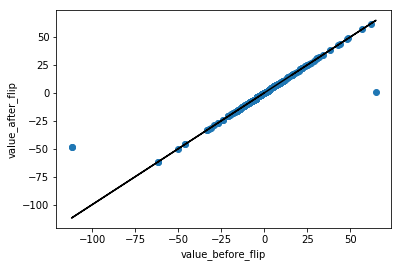

In [48]:

model_type = 'full'
fault_type = fault_types[1]
param_id = 0
bit_position = 1
n_bits = 100

print('fault_rate: %f' %(n_bits*1.0/data[model_type][fault_type][param_id][bit_position][n_bits][0,0]))
print('accuracies:', data[model_type][fault_type][param_id][bit_position][n_bits][:, 2])

folder = 'param-%d/bit-%d/nbits-%d' %(param_id, bit_position, n_bits)
results_dir = os.path.join(get_results_dir(model_name, dataset_name, model_type, fault_type), folder)

avg_params_stats = load_and_average_stats(results_dir, range(3)) 
# print(avg_params_stats)
# plt.bar(range(32), avg_params_stats['flip_to_one'])
# plt.title('flip to one')
# plt.show()

# plt.bar(range(32), avg_params_stats['flip_to_zero'])
# plt.title('flip to zero')
# plt.show() 
print('flip_to_one: %d, flip_to_zero: %d' 
      %(avg_params_stats['flip_to_one'][bit_position], avg_params_stats['flip_to_zero'][bit_position]))

print(list(zip(avg_params_stats['value_before_flip'][:10], avg_params_stats['value_after_flip'][:10])))
plt.plot(avg_params_stats['value_before_flip'], avg_params_stats['value_after_flip'], 'o')
plt.xlabel('value_before_flip')
plt.ylabel('value_after_flip')
plt.plot(avg_params_stats['value_before_flip'], avg_params_stats['value_before_flip'], 'k-')
plt.show()

prec1: 0.9375


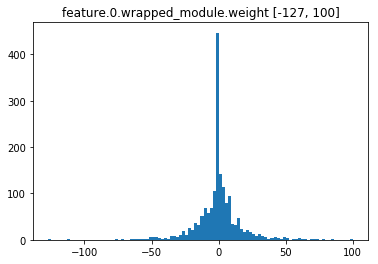

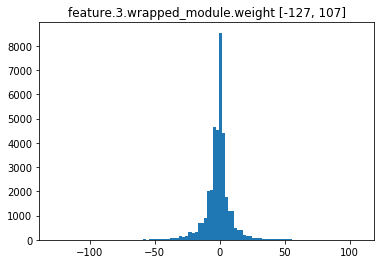

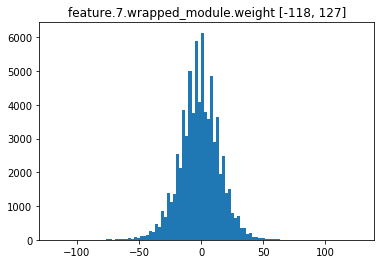

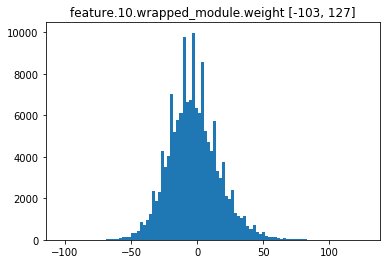

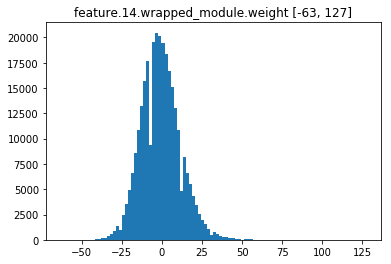

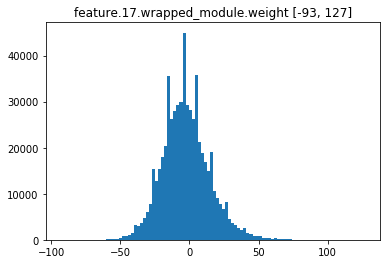

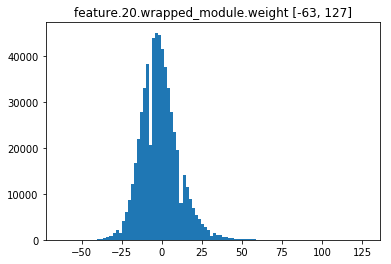

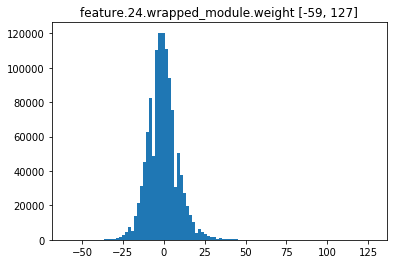

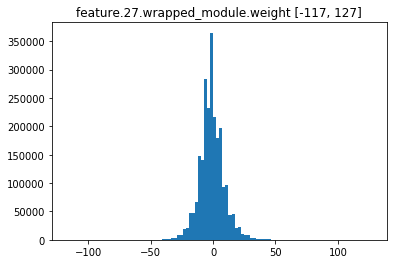

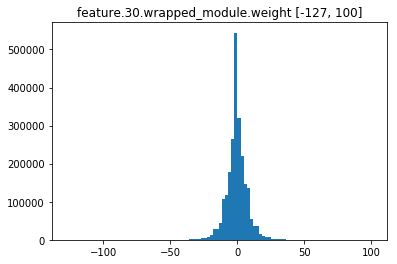

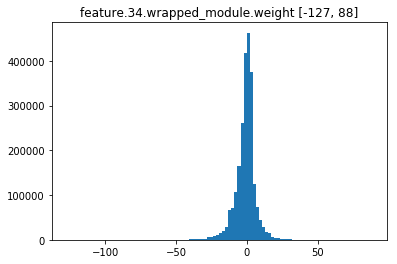

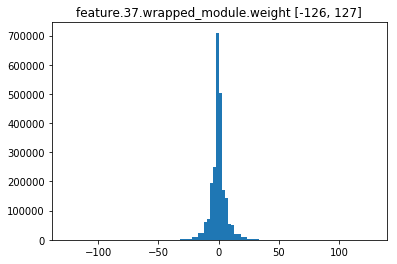

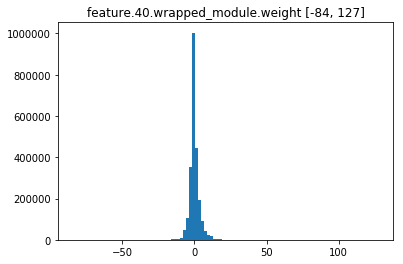

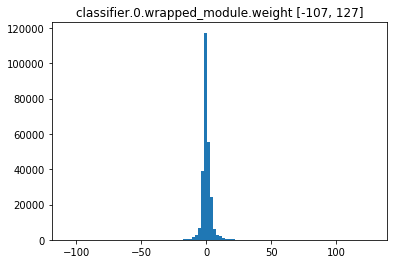

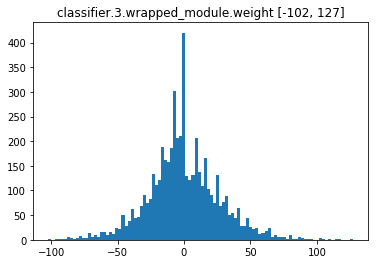

In [12]:
import torch 

model_path = './logs/vgg16/cifar10/int8/quantized.pth.tar'
checkpoint = torch.load(model_path)
prec1 = checkpoint['prec1']
print('prec1:', prec1)
state_dict = checkpoint['state_dict']
for key in state_dict:
    tensor = state_dict[key]
    if len(tensor.size()) < 2:
        continue
    minv, maxv = tensor.min().item(), tensor.max().item() 
    plt.hist(tensor.cpu().numpy().ravel(), bins=100)
    plt.title(key+' [%d, %d]' %(minv, maxv))
    plt.show()